<a href="https://colab.research.google.com/github/yexf308/AdvancedMachineLearning/blob/main/Manifold_Learning_LE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This lecture is partially based on Prof. Guangliang Chen's [course slides.](https://www.sjsu.edu/faculty/guangliang.chen/Math250.html)

In [ ]:
%pylab inline 
from IPython.display import Image
import numpy.linalg as LA

Populating the interactive namespace from numpy and matplotlib


$\def\m#1{\mathbf{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
# Laplacian Eigenmaps
- For dimension reduction

- For clustering (LE + $k$-means = spectral clustering)

Original paper: “Laplacian Eigenmaps for dimensionality reduction and data representation”,
Belkin and Niyogi, Neural Computation 15, 1373–1396 (2003).

**Isomap**:  preserves geodesic distances between **all** points, which means preserving global geometry. 

In contrast, **Laplacian Eigenmaps** will focus on preserving the **local** geometry: nearby points in the original space remain nearby in the reduced space.

## Similarity graphs
Like ISOmap, the first step of Laplacian Eigenmaps is to build a neighborhood graph $G$ from the given data $\m{x}^{(1)}, \dots, \m{x}^{(N)}\in \mb{R}^{D}$ by connecting only “nearby” points, where nearby is defined in one of the following ways: 

- **$\epsilon$-ball approach**.
  - Advantages: Geometrically motivated,
the relationship is naturally symmetric. 
  - Disadvantages: Often
leads to graphs with several connected components, difficult
to choose $\epsilon$

- **$k$-NN approach**.
  - Advantages: Easier to choose; does not tend to lead to
disconnected graphs. 

  - Disadvantages: Less geometrically intuitive.
   

In [ ]:
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/neighbor.png?raw=true', width=800))

However, they use different kinds of weights for the connected edges.
- ISOmap: The edges are weighted by the Euclidean distances:
$$d_\m{X}(i,j) = \|\m{x}^{(i)}-\m{x}^{(j)}\|_2 \qquad \text{if $\m{x}^{(i)}$ and $\m{x}^{(j)}$ are connected.} $$
   We call the correspondingly weighted graph a **dissimilarity graph**.

- Laplacian Eigenmaps: **similarity graph**,
with weights stored in a weight matrix $\m{W}=w_{ij}\in\mb{R}^{N\times N}$. Here we build a similarity graph
via the dissimilarity scores (distances) on vector data in Euclidean spaces.
   - The Euclidean distances between nearby points are transformed to 0/1 similarity scores (to be used as weights): $w_{ij}=1$ if there is an edge between $\m{x}^{(i)}$ and $\m{x}^{(j)}$,  and 0, otherwise. This
leads to a sparse graph.

   - We may construct a fully connected graph using Gaussian weights $w_{ij}= \exp(-d_\m{X}^2(i,j)/t)$ for all pairs of points $\m{x}^{(i)}$ and $\m{x}^{(j)}$ when $i\ne j$ ($t>0$ is a parameter set by the user). For $i=j$, we denote $W_{ij}=0$. A reasonably large value of $t$ leads to large weights only for close neighbors. Sometimes, only put the Gaussian weights if $i$ and $j$ are connected, otherwise, put $W_{ij}=0$. 

   - In many other scenarios, the similarity graph can be specified directly. For example, we may build a **similarity graph** over a group of people by assigning the similarity of any two people as the number of friends they have in common.

**The effective input to Laplacian Eigenmaps is a similarity graph.** The algorithm will then try to find a representation of the nodes in a low-dimensional Euclidean space by preserving locality information.   
     

## Example
The following displays a similarity graph on a set of 5 data
points (called vertices or nodes), with associated weight matrix $\m{W}$.
\begin{align}
 \m{W}=\begin{pmatrix}0 & 0.8 & 0.8 & 0 & 0 \\ 
                        0.8 & 0 & 0.8 & 0 & 0 \\ 
                        0.8 & 0.8 & 0 & 0.1 & 0 \\ 
                        0 & 0&0.1 & 0 & 0.9 \\ 
                        0 & 0 & 0 &0.9 & 0 \end{pmatrix}
\end{align}

In [ ]:
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/graph.png?raw=true', width=500))

## 1D dimension reduction by Laplacian Eigenmaps
Key point of Laplacian Eigenmaps: **Locality-preserving**!

Assuming a weighted similarity graph (constructed on the given data set), we first consider the problem of **mapping the graph to a line** in a way such that close neighbors on the graph are still close on the line. 


---
Let $\m{Z}=(\m{z}^{(1)}, \dots, \m{z}^{(N)})^\top$ represent the 1D embedding of the nodes. We then formulate the following problem:
$$ \min_{\m{f}\in\mb{R}^N}\frac{1}{2}\sum_{ij}w_{ij}(\m{z}^{(i)} - \m{z}^{(j)})^2$$

**Interpretation:**
- If $w_{ij}$ is large (close to 1, meaning $\m{x}^{(i)}$, $\m{x}^{(j)}$ are originally very close),
then $\m{z}^{(i)}, \m{z}^{(j)}$ must still be close (otherwise there is a heavy penalty).

- If $w_{ij}$ is small (close to 0, meaning $\m{x}^{(i)}$, $\m{x}^{(j)}$ are originally very far), then there is much flexibility in putting $\m{z}^{(i)}$, $\m{z}^{(j)}$ on the line.

However, the problem $ \min_{\m{f}\in\mb{R}^N}\frac{1}{2}\sum_{ij}w_{ij}(\m{z}^{(i)} - \m{z}^{(j)})^2$ is not well defined. Because $\m{Z}=\mb{0}$ and $\mb{1}$ are the trivial solution. 

### Mathematical Formulation
To get rid of the scaling and translational invariances in $\m{Z}$ and these trivial solutions. We will add the following constraints on $\m{Z}$: 
$$ \min_{\m{Z}\in\mb{R}^N}\frac{1}{2}\sum_{ij}w_{ij}(\m{z}^{(i)} - \m{z}^{(j)})^2, \ \text{subject to}\ \sum_i \m{z}^{(i)}=0, \sum_{i} (\m{z}^{(i)})^2=1.$$

Equivalently, it can be reformulated as an unconstrained problem:
$$ \min_{\m{Z}^\top \mb{1}=0, \|\m{Z}\|=1}\frac{1}{2}\sum_{ij}w_{ij}(\m{z}^{(i)} - \m{z}^{(j)})^2 \ \text{or} \  \min_{\m{Z}^\top \mb{1}=0,\m{Z}\ne 0}\frac{\frac{1}{2}\sum_{ij}w_{ij}(\m{z}^{(i)} - \m{z}^{(j)})^2}{\sum_{i} (\m{z}^{(i)})^2}$$


The original Laplacian eigenmaps algorithm proposed by Belkin and Niyogi (2003) uses a different set of constraints placed on $\m{z}$ for
eliminating the trivial solutions:
$$ \m{Z}^\top \m{D}\mb{1} = \sum_{i}d_i \m{z}^{(i)}=0,\qquad \m{Z}^\top \m{D}\m{Z} = \sum_i d_i (\m{z}^{(i)})^2 =1$$
We will compare them later! 

## Spectral graph theory
We will present some graph terminology and theory.

Let $G=(V, E, \m{W})$ be a weighted graph with vertices $V=\{1,\dots, N\}$ and weights $w_{ij}\ge 0$. There is an edge $e_{ij}\in E$ connecting nodes $i$ and $j$ iff $w_{ij}>0$ and $i$ and $j$ are called **adjacent**. 

When the binary weighting method is used (i.e., all positive weights are equal to 1), the weight matrix $\m{W}$ is also referred to as the **adjacency matrix**.

The degree of a vertex $i\in V$ is defined as $d_i=\sum_{j=1}^N w_{ij}$. 
It measures the connectivity of the vertex in the graph. For example. 

The degrees of all vertices can be used to form a degree matrix $\m{D}=\text{diag}(d_1, \dots, d_N)\in \mb{R}^{N\times N}$. An equivalent way of defining the degree matrix is $\m{D}= \text{diag}(\m{W}\mb{1})$.

With the example above, 
$$\m{D}=\text{diag}(1.6, 1.6, 1.7, 1, 0.9). $$

### Graph Laplacian 
**Definition**: Given a graph $G=(V, E, \m{W})$ with size $|V|=N$, the graph Laplacian is defined as the following matrix,
 $$ \m{L}=\m{D}-\m{W}\in \mb{R}^{N\times N},\ \text{where }\m{D}= \text{diag}(\m{W}\mb{1}). $$

**Property**: Let $\m{L}\in \mb{R}^{N\times N}$ be a graph Laplacian matrix.

- $\m{L}$ is symmetric.

- All the rows (and columns) sum to 0, i.e., $\m{L}\mb{1}=\mb{0}$. This implies that $\m{L}$ has a eigenvalue 0 with eigenvector $\mb{1}\in \mb{R}^N$.

- For every $\m{Z}\in \mb{R}^N$, we have 
$$\m{Z}^\top \m{L}\m{Z}=\frac{1}{2}\sum_{i,j}w_{ij}(\m{z}^{(i)}-\m{z}^{(j)})^2. $$
This implies that $\m{L}$ is positive semidefinite and accordingly, its eigenvalues are all nonnegative: $0=\lambda_1 \le \lambda_2\dots \le \lambda_N$.

- The algebraic (and also geometric) multiplicity of the eigenvalue 0 equals the number of connected components of the graph.

A little bit derivation:

\begin{align}
&\frac{1}{2}\sum_{i,j}\left(w_{ij}(\m{z}^{(i)})^2+w_{ij}(\m{z}^{(j)})^2 - 2w_{ij}\m{z}^{(i)} \m{z}^{(j)} \right) =\sum_{ij} w_{ij}(\m{z}^{(i)})^2-w_{ij}\m{z}^{(i)} \m{z}^{(j)} \\
&=\sum_i (\sum_j w_{ij})(\m{z}^{(i)})^2-\sum_{ij}\m{z}^{(i)} w_{ij}\m{z}^{(j)} \\
& =\m{Z}^\top (\m{D}-\m{W})\m{Z} =\m{Z}^\top \m{L}\m{Z}
\end{align}


For the example above (which is connected), 
\begin{align}
 \m{L}=\begin{pmatrix}1.6 & -0.8 & -0.8 & 0 & 0 \\ 
                        -0.8 & 1.6 & -0.8 & 0 & 0 \\ 
                        -0.8 & -0.8 & 1.7 & -0.1 & 0 \\ 
                        0 & 0&-0.1 & 1 & -0.9 \\ 
                        0 & 0 & 0 &-0.9 & 0.9 \end{pmatrix}
\end{align}


the eigenvalues
of the graph Laplacian are $0 < 0.0788 < 1.8465 < 2.4000 < 2.4747$.








---


Consider the modified graph (which has two connected
components)

\begin{align}
 \m{W}=\begin{pmatrix}0 & 0.8 & 0.8 & 0 & 0 \\ 
                        0.8 & 0 & 0.8 & 0 & 0 \\ 
                        0.8 & 0.8 & 0 & 0 & 0 \\ 
                        0 & 0&0 & 0 & 0.9 \\ 
                        0 & 0 & 0 &0.9 & 0 \end{pmatrix}
\end{align}


It can be shown that
$$ \text{det}(\lambda \m{I}-\m{L})=\lambda^2(\lambda -2.4)^2(\lambda-1.8)$$

Thus, the graph Laplacian has a repeated eigenvalue 0, with multiplicity 2 (which is equal to the number of connected components).



---


Another example with binary weighting, then $\m{W}$ is the adjacency matrix. 

In [ ]:
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/laplacian.png?raw=true', width=800))

## Back to 1D Laplacian Eigenmaps problem

It embeds the nodes of a similarity graph $G=(V, E, \m{W})$ into a line:

$$ \min_{\m{Z}^\top \mb{1}=0,\m{Z}\ne 0}\frac{\frac{1}{2}\sum_{ij}w_{ij}(\m{z}^{(i)} - \m{z}^{(j)})^2}{\sum_{i} (\m{z}^{(i)})^2}$$

With the help of graph laplacian, we can rewrite the above
problem as follows:
$$ \min_{\m{Z}^\top \mb{1}=0,\m{Z}\ne 0} \frac{\m{Z}^\top \m{L}\m{Z}}{\m{Z}^\top\m{Z}}$$

This is a **Rayleigh quotient problem** with an
extra constraint!! Refer to [PCA](https://github.com/yexf308/MAT592/blob/main/Module2/PCA1.ipynb).

- **Without the extra constraint $\m{Z}^\top\mb{1}=0$**, a minimizer of the Rayleigh quotient is an eigenvector of the graph Laplacian $\m{L}$ corresponding to the smallest eigenvalue $\lambda_1=0$ is $\m{Z}^*=\m{v}_1=\mb{1}$. Because the objective function is always non-negative and $\m{Z}^*=\mb{1}$ gives the value 0. 

  However, this is a trivial solution which puts all nodes of the graph at the same point of a line.

- **With the extra constraint**, we force $\m{Z}$ to be **perpendicular to the smallest eigenvector**. The minimizer of this new problem is given by the second smallest eigenvector of $\m{L}$, $\m{Z}^*=\m{v}_2$ and the minimum value of the Rayleigh quotient is $\lambda_2$. 

- Remember if the similarity graph is connected (which is the interesting, nontrivial
case), the algebraic (and geometric) multiplicity of the eigenvalue 0 is one. Consequently, we must have $\lambda_2>0$, and $(\m{Z}^*)^\top\m{L}\m{Z}^* = \lambda_2 (\m{Z}^{*})^2 >0  $. This shows that $\m{Z}^*=\m{v}_2$ will lead to a nontrivial embedding of the graph.


For the graph below (which is connected), the second smallest
eigenvector is $\lambda_2 =0.0788, \m{v}_2= (−.3771,−.3771,−.3400, .5221, .5722).$ It splits into two parts, left three vertices and right two vertices. 

## Original Laplacian Eigenmaps algorithm
The original Laplacian
Eigenmaps algorithm proposed by Belkin and Niyogi (2003) corresponds
to solving the following problem:
$$ \min_{\m{Z}^\top \m{D}\mb{1}=0,\m{Z}\ne 0}\frac{\m{Z}^\top \m{L}\m{Z}}{\m{Z}^\top\m{D}\m{Z}}$$

Similarly, $\m{Z}^\top\m{D}\m{Z}$ removes the scaling factor and the constraint $\m{Z}^\top \m{D}\mb{1}=0$ removes the translational invariance and the trivial solution. 

This is a **generalized Rayleigh quotient problem** with an
extra constraint!!

- **Without the extra constraint $\m{Z}^\top\m{D}\mb{1}=0$**, the solution of the generalized
Rayleigh quotient problem is the smallest eigenvector $\m{v}_1$ of $\m{D^{-1}L}$, $\ \m{D^{-1}L}\m{v}_1=\lambda_1\m{v}_1 $, which is the trivial solution $\m{Z}^*=\mb{1}$ The reason is 
  -  $\frac{\m{Z}^\top \m{L}\m{Z}}{\m{Z}^\top\m{D}\m{Z}}\ge 0 $ and $\frac{\mb{1}^\top \m{L}\mb{1}}{\mb{1}^\top\m{D}\mb{1}}=0$. So $\m{Z}^{*}=\mb{1}$ is the minimizer. 
  - $\m{D^{-1}L} \mb{1}=\m{D^{-1}}(\m{L}\mb{1})=0\cdot \mb{1}$. This implies $\m{v}_1=\mb{1}$ for the smallest eigenvalue $\lambda_1=0$. 




### Normalized Graph Laplacian.


Given a graph $G=(V, E, \m{W})$ with size $|V|=N$ and the graph Laplacian $\m{L}=\m{D}-\m{W}$. 
-  Random walk normalized Laplacian is defined as $\m{L}^{\text{rw}}=\m{D}^{-1}\m{L}$.
The element of $\m{L}^{\text{rw}}$ is 
\begin{align}
\m{L}^{\text{rw}}_{ij} =  
\begin{cases}1 &\text{if $i=j$ and $d_i\ne 0$} \\ 
             -\frac{w_{ij}}{d_i} & \text{if $i\ne j$ and $w_{ij}>0$} \\
             0 & \text{Otherwise}\end{cases}  
\end{align}

- Symmetric normalized Laplacian is defined as $\m{L}^{\text{sym}}=\m{D}^{-1/2}\m{L}\m{D}^{-1/2}$. The element of $\m{L}^{\text{sym}}$ is 
\begin{align}
\m{L}^{\text{sym}}_{ij} =  
\begin{cases}1 &\text{if $i=j$ and $d_i\ne 0$} \\ 
             -\frac{w_{ij}}{\sqrt{d_id_j}} & \text{if $i\ne j$ and $w_{ij}>0$} \\
             0 & \text{Otherwise}\end{cases}  
\end{align}

**Property**:
- $\m{L}^{\text{rw}}\mb{1}=\mb{0}$, the row sums are 1 and it has eigenvalue 0 with eigenvector $\mb{1}$. But $\m{L}^{\text{sym}}\mb{1}\ne\mb{0}$.

- $\m{L}^{\text{sym}}$ is symmetric and PSD, while $\m{L}^{\text{rw}}$ is not, but they are similar. 
 $$ \underbrace{\m{D^{-1}L}}_{\m{L}^{\text{rw}}}=\m{D^{-1/2}}\underbrace{\m{D^{-1/2}LD^{-1/2}}}_{\m{L}^{\text{sym}}}\m{D^{1/2}}$$
 This implies that both matrices have the same eigenvalues
 $$0=\lambda_1\le \lambda_2\le \dots \le\lambda_N $$
 
- Additionally, it can be shown that the multiplicity of the 0 eigenvalue
is also equal to the number of connected components in the graph.

- A vector $\m{v}$ is an eigenvector of $\m{L}^{\text{rw}}$ iff the vector $\m{D^{-1}v}$ is an eigenvector of $\m{L}^{\text{sym}}$.

$$ \m{D^{-1}L}\m{v}=\lambda \m{v} \leftrightarrow  \m{D^{-1/2}LD^{-1/2}}\m{D^{1/2}v}=\lambda \m{D^{1/2} v}$$
  In particular, for the eigenvalue $\lambda_1=0$, the associated eigenvectors for $\m{L}^{\text{rw}}$ and $\m{L}^{\text{sym}}$ are 

  - $\m{L}^{\text{rw}}$: $\m{v}_1=\mb{1}$

  -  $\m{L}^{\text{sym}}$: $\m{v}_1=\m{D}^{1/2}\mb{1}$

### Solve original Laplacian Eigenmaps
When the graph is connected, we will show that the minimizer is given by the second smallest eigenvector of $\m{L}^{\text{rw}}=\m{D^{-1}L}$.

- First, change of variables $\tilde{\m{Z}}= \m{D}^{1/2}\m{Z}$ such that 
$$ \m{Z}^\top \m{L}\m{Z}=\m{Z}^\top  \m{D}^{1/2}  \m{D}^{-1/2}\m{L} \m{D}^{-1/2} \m{D}^{1/2}\m{Z}=\tilde{\m{Z}}^{\top}\m{L}^{\text{sym}}\tilde{\m{Z}} $$

$$\m{Z}^\top \m{D}\m{Z}=\m{Z}^\top \m{D}^{1/2}\m{D}^{1/2}\m{Z}= \tilde{\m{Z}}^{\top}\tilde{\m{Z}}$$

- Then we obtain the following equivalent problem, which is a Rayleigh quotient problem: 
   $$ \min_{\tilde{\m{Z}}^\top (\m{D}^{1/2}\mb{1})=0,\tilde{\m{Z}}\ne 0} \frac{\tilde{\m{Z}}^\top \m{L}^{\text{sym}}\tilde{\m{Z}}}{\tilde{\m{Z}}^\top\tilde{\m{Z}}}$$

- It is equivalent with the previous optimization problem. Then the optimal $\tilde{\m{Z}}$ is given by the second smallest eigenvector of $\m{L}^{\text{sym}}$. Because $\m{D}^{1/2}\mb{1}$ is the eigenvector corresponding to the smallest eigenvalue $\lambda_1=0$.

- In the original variable $\m{Z}$, this becomes
$$\m{L}^{\text{sym}} \m{D}^{1/2}\m{Z}=\lambda_2 \m{D}^{1/2}\m{Z} \rightarrow \m{D^{-1}L}\m{Z}=\lambda_2 \m{Z}$$

Thus the optimal $\m{Z}$ is given by the second smallest eigenvector of $\m{L}^{\text{rw}}$. 

With the example above, the normalized graph Laplacian is 
\begin{align}
 \m{D^{-1}L}=\begin{pmatrix}1 & -0.5 & -0.5 & 0 & 0 \\ 
                        -0.5 & 1 & -0.5 & 0 & 0 \\ 
                        −0.4706 & −0.4706 & 1& −0.0588 & 0 \\ 
                        0 & 0&-0.1 & 1 & -0.9 \\ 
                        0 & 0 & 0 &-1 & 1 \end{pmatrix}
\end{align}
Its second smallest eigenvector (corresponding to  $\lambda_2 = 0.0693$) is
$$\m{v}_2 = (−0.2594,−0.2594,−0.2235, 0.6152, 0.6610).$$

Compare with the unnormalized graph Laplacian $\m{L}$:
$$\lambda_2 =0.0788, \m{v}_2 = (−0.3771,−0.3771,−0.3400, 0.5221, 0.5722) $$



### Which graph Laplacian $\m{L}, \m{L}^{\text{rw}}$ should be used?

 They correspond to two different formulations of the embedding problem
$$  \min_{\m{Z}^\top \mb{1}=0,\m{Z}\ne 0} \frac{\m{Z}^\top \m{L}\m{Z}}{\m{Z}^\top\m{Z}} \ \text{ verse  } \ \min_{\m{Z}^\top \m{D}\mb{1}=0,\m{Z}\ne 0}\frac{\m{Z}^\top \m{L}\m{Z}}{\m{Z}^\top\m{D}\m{Z}}  $$

The two criteria work the same when all nodes of the graph have the same degrees (i.e., $\m{D}=\lambda\m{I}$ for some $\lambda>0$.)

In general, the **normalized graph Laplacian** should be used.



## Embedding graph data to 2D or higher
To produce a $d$-dimensional embedding of the nodes of a connected graph $G=(V, E, \m{W})$, one can just take more eigenvectors of the normalized Laplacian $\m{L}^{\text{rw}}=\m{D}^{-1}\m{L}$, i.e, the embedding matrix is 
\begin{align}
\m{Z} =[\m{v}_2, \dots, \m{v}_{d+1}]\in \mb{R}^{N\times d} 
\end{align}
The rows of $\m{Z}$ are new coordinates for the original data points $\m{x}^{(i)}\in \mb{R}^d$.

Equivalently, we could formulate the following minimization problem over a $d$-dimensional embedding matrix $\m{Z}=[\m{z}^{(1)}, \dots, \m{z}^{(N)}]^\top \in \mb{R}^{N\times d}$,
$$\min_{\m{Z}^\top \m{D}\m{Z}=\m{I}, \m{Z}^\top \m{D} \mb{1}=\mb{0}}\frac{1}{2}\sum_{ij}w_{ij}\|\m{z}^{(i)}-\m{z}^{(j)}\|^2=\min_{\m{Z}^\top \m{D}\m{Z}=\m{I}, \m{Z}^\top \m{D} \mb{1}=\mb{0}}\text{trace}(\m{Z}^\top \m{L}\m{Z}) $$
It turns out that the solution is given by the same eigenvectors of $\m{L}^{\text{rw}}$. 


## The Laplacian Eigenmaps algorithm
**Input:** Similarity graph $G=(V, E, \m{W})$, embedding dimension $d$.

**Output:** A $d$-dimensional representation of the input data ($\m{Z}\in\mb{R}^{N\times d}$). 

- Compute the normalized graph Laplacian
$$ \m{L}^{\text{rw}} =\m{D}^{-1}\m{L}= \m{I}-\m{D}^{-1}\m{W}$$
where $\m{D}=\text{diag}(\m{W}\mb{1})$.

- Find the eigenvectors of $\m{L}^{\text{rw}}$ corresponding to the second to $(d+1)$st smallest eigenvalues
 $$\m{L}^{\text{rw}} \m{v}_i = \lambda_i\m{v}_i, \qquad i=2,\dots,d+1 $$

- Return: $\m{Z}=[\m{v}_2, \dots, \m{v}_{d+1}]\in \mb{R}^{N\times d}.$


In [ ]:
from scipy.sparse.csgraph import connected_components

def similarity(dist,t):
  return exp(- (dist*dist)/t) 


def eps_ball(dist_matrix,eps):
   '''Output the index of nearest neighbor for each i'''
   N = dist_matrix.shape[1]
   nn_matrix = []
   for i in range(N):
     nn_i = []
     for index, d in enumerate(dist_matrix[i,:]):
       if d < eps and index != i:
         nn_i.append(index)
     nn_matrix.append(nn_i)

   return nn_matrix      



## KNN to be done.

In [ ]:
def construct_nearest_graph(dist_matrix, method, t):
  """ Compute weight matrix W"""
  nn_matrix = method['fun'](dist_matrix, method['para'])
  N = dist_matrix.shape[1]
  # weight matrix
  W = zeros([N,N])
  for i in range(N):
    for v in nn_matrix[i]:
      W[i,v] = similarity(dist_matrix[i,v],t)
  
  # Check for connectivity
  G =W.copy()
  G[G > 0] = 1  
  n_components = connected_components(csgraph=G, directed=False, return_labels=False)
  return W, n_components


In [ ]:
def optimum_epsilon(dist_matrix, opt_eps_jumps, t):
  """
  Compute epsilon for eps_ball
        
  To chose the minimum epsilon which guarantees G to be 
  connected, first, epsilon is set to be equal to the distance 
  from observation i = 0 to its nearest neighbour. Then
  we check if the Graph is connected, if it's not, epsilon
  is increased and the process is repeated until the Graph
  is connected
  """
  eps = min(dist_matrix[0,1:])
  con = False
  while not con:
     eps     = opt_eps_jumps *eps
     method = {'fun':  eps_ball,
                'para': eps}
     W, n_components =construct_nearest_graph(dist_matrix, method, t)
     con = n_components == 1
  return eps, W



In [ ]:
def LE(dist_matrix, method, options,t,d):

  opt_eps_jumps = 1.4
  eps, W = optimum_epsilon(dist_matrix, opt_eps_jumps, t)
  method['para']=eps

  N = dist_matrix.shape[1]
  D = diag(W.sum(axis=1))  
  L = D - W # unnormalized_laplacian
  
  if options == 'unnormalized':
    eigval, eigvec = eigh(L)
  elif  options == 'random':
    Lr = eye(N)- (diag(1/D.diagonal())@W) # normalized_random_laplacian
    eigval, eigvec = eig(Lr)
  else:
    d_half = diag(1/sqrt(D.diagonal()))
    Ls =  d_half @ ( L @ d_half ) # normalized_symmetrized_laplacian
    eigval, eigvec = eigh(Ls)

  order = argsort(eigval)  
  Z = eigvec[:, order[1:d + 1]]

  return Z, eigval[order],method



In [ ]:
def LE_full(dist_matrix, options,t,d):
  W = similarity(dist_matrix,t)
  np.fill_diagonal(W,0) # Diagonal of graph laplacian is zero. 
  N = dist_matrix.shape[1]
  D = diag(W.sum(axis=1))  
  L = D - W # unnormalized_laplacian
  
  if options == 'unnormalized':
    eigval, eigvec = eigh(L)
  elif  options == 'random':
    Lr = eye(N)- (diag(1/D.diagonal())@W) # normalized_random_laplacian
    eigval, eigvec = eig(Lr)
  else:
    d_half = diag(1/sqrt(D.diagonal()))
    Ls =  d_half @ ( L @ d_half ) # normalized_symmetrized_laplacian
    eigval, eigvec = eigh(Ls)

  order = argsort(eigval)  
  Z = eigvec[:, order[1:d + 1]]

  return Z, eigval[order]



# Swiss roll

In [ ]:
from sklearn.datasets import make_swiss_roll
import plotly.express as px

n_samples = 1000
noise = 0.05
X, color = make_swiss_roll(n_samples, noise=noise)

N = X.shape[0]
dist_matrix = zeros([N,N])
for i in range(N):
  for j in range(N):
    dist_matrix[i,j]=norm(X[i]-X[j],2)

In [ ]:
W1 = similarity(dist_matrix,t)
np.fill_diagonal(W1,0) # Diagonal of graph laplacian is zero. 

opt_eps_jumps = 1.4
eps, W2 = optimum_epsilon(dist_matrix, opt_eps_jumps, t)


In [ ]:
W2[0,109]

0.9504040171891968

In [ ]:
W1[0,109]

0.9504040171891968

In [ ]:
method = {'fun':  eps_ball,
          'para': 2}
t =3    
d =2 
options = 'random'     

In [ ]:
Z, eigval,method = LE(dist_matrix, method, 'random',t,d)

In [ ]:
Z_full, eigval = LE_full(dist_matrix,  'random',t,d)

In [ ]:
fig =  px.scatter(x=Z[:, 0], y=Z[:, 1], color=color)
fig.show()

In [ ]:
fig =  px.scatter(x=Z_full[:, 0], y=Z_full[:, 1], color=color)
fig.show()

#Handwritten digits

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits() 

X = digits.data
y = digits.target 

N = X.shape[0]
dist_matrix = zeros([N,N])
for i in range(N):
  for j in range(N):
    dist_matrix[i,j]=norm(X[i]-X[j])

In [ ]:
from matplotlib import offsetbox

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        color=(y[i]+1) / 11.0 # ensure each digit gets unique color
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(color),
                 fontdict={'weight': 'bold', 'size': 9})
        
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)    
            
    plt.xticks([]), plt.yticks([])

In [ ]:
method = {'fun':  eps_ball,
          'para': 40}
t =400   
d =2 
options = 'random' 

In [ ]:
Z, eigval,method = LE(dist_matrix, method, 'random',t,d)

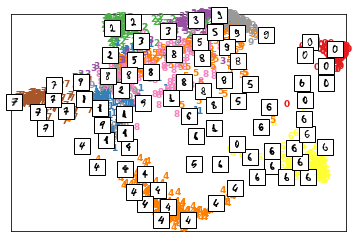

In [ ]:
plot_embedding(Z)

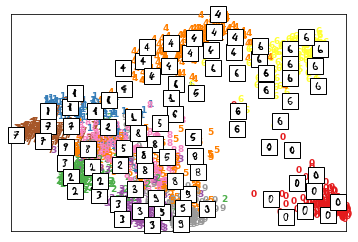

In [ ]:
Z_full, eigval = LE_full(dist_matrix,  'random',t,d)
plot_embedding(Z_full)